## I.Preparing the text for LDA

### Import libraries

In [ ]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install keybert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import re,spacy
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from keybert import KeyBERT
import numpy as np
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load dataset

In [ ]:
df = pd.read_json('DataBase.json')

Visualize most common words using wordcloud

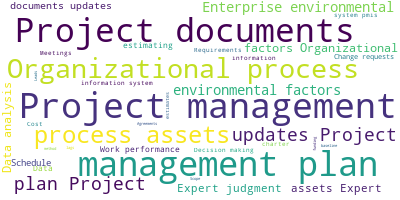

In [ ]:
# Join the different processed titles together.
all_titles = ','.join(list(df['Title_4'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(all_titles)

# Visualize the word cloud
wordcloud.to_image()

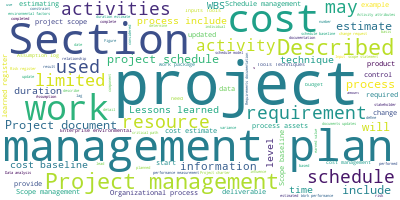

In [ ]:
# Join the different processed titles together.
all_corpus = ','.join(list(df['Corpus'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(all_corpus)

# Visualize the word cloud
wordcloud.to_image()

#### Tokenization and Removing Stop words

In [ ]:
stop_words = stopwords.words('english')
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = df.Corpus.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['project', 'scope', 'management', 'includes', 'processes', 'required', 'ensure', 'project', 'includes', 'work', 'required', 'work', 'required', 'complete', 'project', 'successfully', 'managing', 'project', 'scope', 'primarily', 'concerned', 'deﬁning', 'controlling', 'included', 'project', 'project', 'scope', 'management', 'processes', 'plan']


#### Lemmatization

In [ ]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [ ]:
print(data_words[10])
print(data_lemmatized[10])

['requirements', 'management', 'plan', 'component', 'project', 'management', 'plan', 'describes', 'project', 'product', 'requirements', 'analyzed', 'documented', 'managed', 'according', 'business', 'analysis', 'practitioners', 'practice', 'organizations', 'refer', 'business', 'analysis', 'plan', 'components', 'requirements', 'management', 'plan', 'include', 'limited', 'requirements', 'activities', 'planned', 'tracked', 'reported', 'conﬁguration', 'management', 'activities', 'changes', 'initiated', 'impacts', 'analyzed', 'traced', 'tracked', 'reported', 'well', 'authorization', 'levels', 'required', 'approve', 'changes', 'requirements', 'prioritization', 'process', 'metrics', 'used', 'rationale', 'using', 'traceability', 'structure', 'reﬂects', 'requirement', 'attributes', 'captured', 'traceability', 'matrix']
requirement management plan component project management plan describe project product requirement analyze document manage accord business analysis practitioner practice organizat

#### Keywords Extraction using Keybert
##### KeyBERT is a minimal and easy-to-use keyword extraction technique that leverages BERT embeddings to create keywords and keyphrases that are most similar to a document.



In [ ]:
doc = all_corpus
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(doc)
print(keywords)

[('scope', 0.5075), ('management', 0.3495), ('objectives', 0.3441), ('managing', 0.341), ('processes', 0.329)]


##### The output is a list of tuples where the first index in the tuple is the string value for the key and the second value is the  for distance of the key which can be thought of as a score to reflect the model's certainly between the range of 0 to 1  with higher values being more certain.

### Calculate texts similarities using SentenceTransformer(HuggingFace's library)
##### SentenceTransformers is a Python framework for state-of-the-art sentence, text and image embeddings,based on PyTorch and Transformers and offers a large collection of pre-trained models tuned for various tasks.
##### Using This framework we compute sentence / text embeddings. These embeddings will then be compared with cosine-similarity to find sentences with a similar meaning.


In [ ]:
sen = data_lemmatized
model_sentence = SentenceTransformer('bert-base-nli-mean-tokens')
#Encoding:
sen_embeddings = model_sentence.encode(sen)
sen_embeddings.shape
model_sentence.shape

(216, 768)

In [ ]:
#let's calculate cosine similarity for sentence 0:
cosine_similarity(
    [sen_embeddings[0]],
    sen_embeddings[1:]
)

array([[0.81561154, 0.7961386 , 0.8060047 , 0.5144989 , 0.60119474,
        0.67259264, 0.8104982 , 0.64652306, 0.9381429 , 0.7639681 ,
        0.7757582 , 0.7966678 , 0.7725954 , 0.757025  , 0.6258414 ,
        0.76131237, 0.51757634, 0.5972105 , 0.70640785, 0.5723948 ,
        0.6643031 , 0.6392758 , 0.6150694 , 0.5726559 , 0.5554156 ,
        0.6493216 , 0.7657588 , 0.77850753, 0.80393636, 0.80605054,
        0.7001649 , 0.76111925, 0.48746246, 0.6674483 , 0.55932975,
        0.6281673 , 0.7730367 , 0.72112286, 0.79724365, 0.9273236 ,
        0.75740564, 0.81713873, 0.73940885, 0.7647542 , 0.6228878 ,
        0.6584171 , 0.55932975, 0.806328  , 0.870226  , 0.77375937,
        0.8556472 , 0.86969376, 0.7450571 , 0.7660071 , 0.64712346,
        0.6998672 , 0.5738309 , 0.67483187, 0.7680081 , 0.75992465,
        0.7220825 , 0.81565547, 0.79660046, 0.7351787 , 0.6709695 ,
        0.6125233 , 0.754601  , 0.7245187 , 0.7233696 , 0.7615022 ,
        0.68618804, 0.9380916 , 0.77620804, 0.74

# II.  Topic Models
#### In statistics and natural language processing Topic modeling is an unsupervised machine learning technique that can scan a collection of documents, detect word and phrase patterns within them, and automatically cluster word groups and similar expressions that best characterize the collection of documents.

#### Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body.
#### In a practical and more intuitively, you can think of it as a task of:


*  Dimensionality Reduction, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}

*   Unsupervised Learning, where it can be compared to clustering, as in the case of clustering, the number of topics, like the number of clusters, is an output parameter. By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight.

*   Tagging, abstract “topics” that occur in a collection of documents that best represents the information in them.





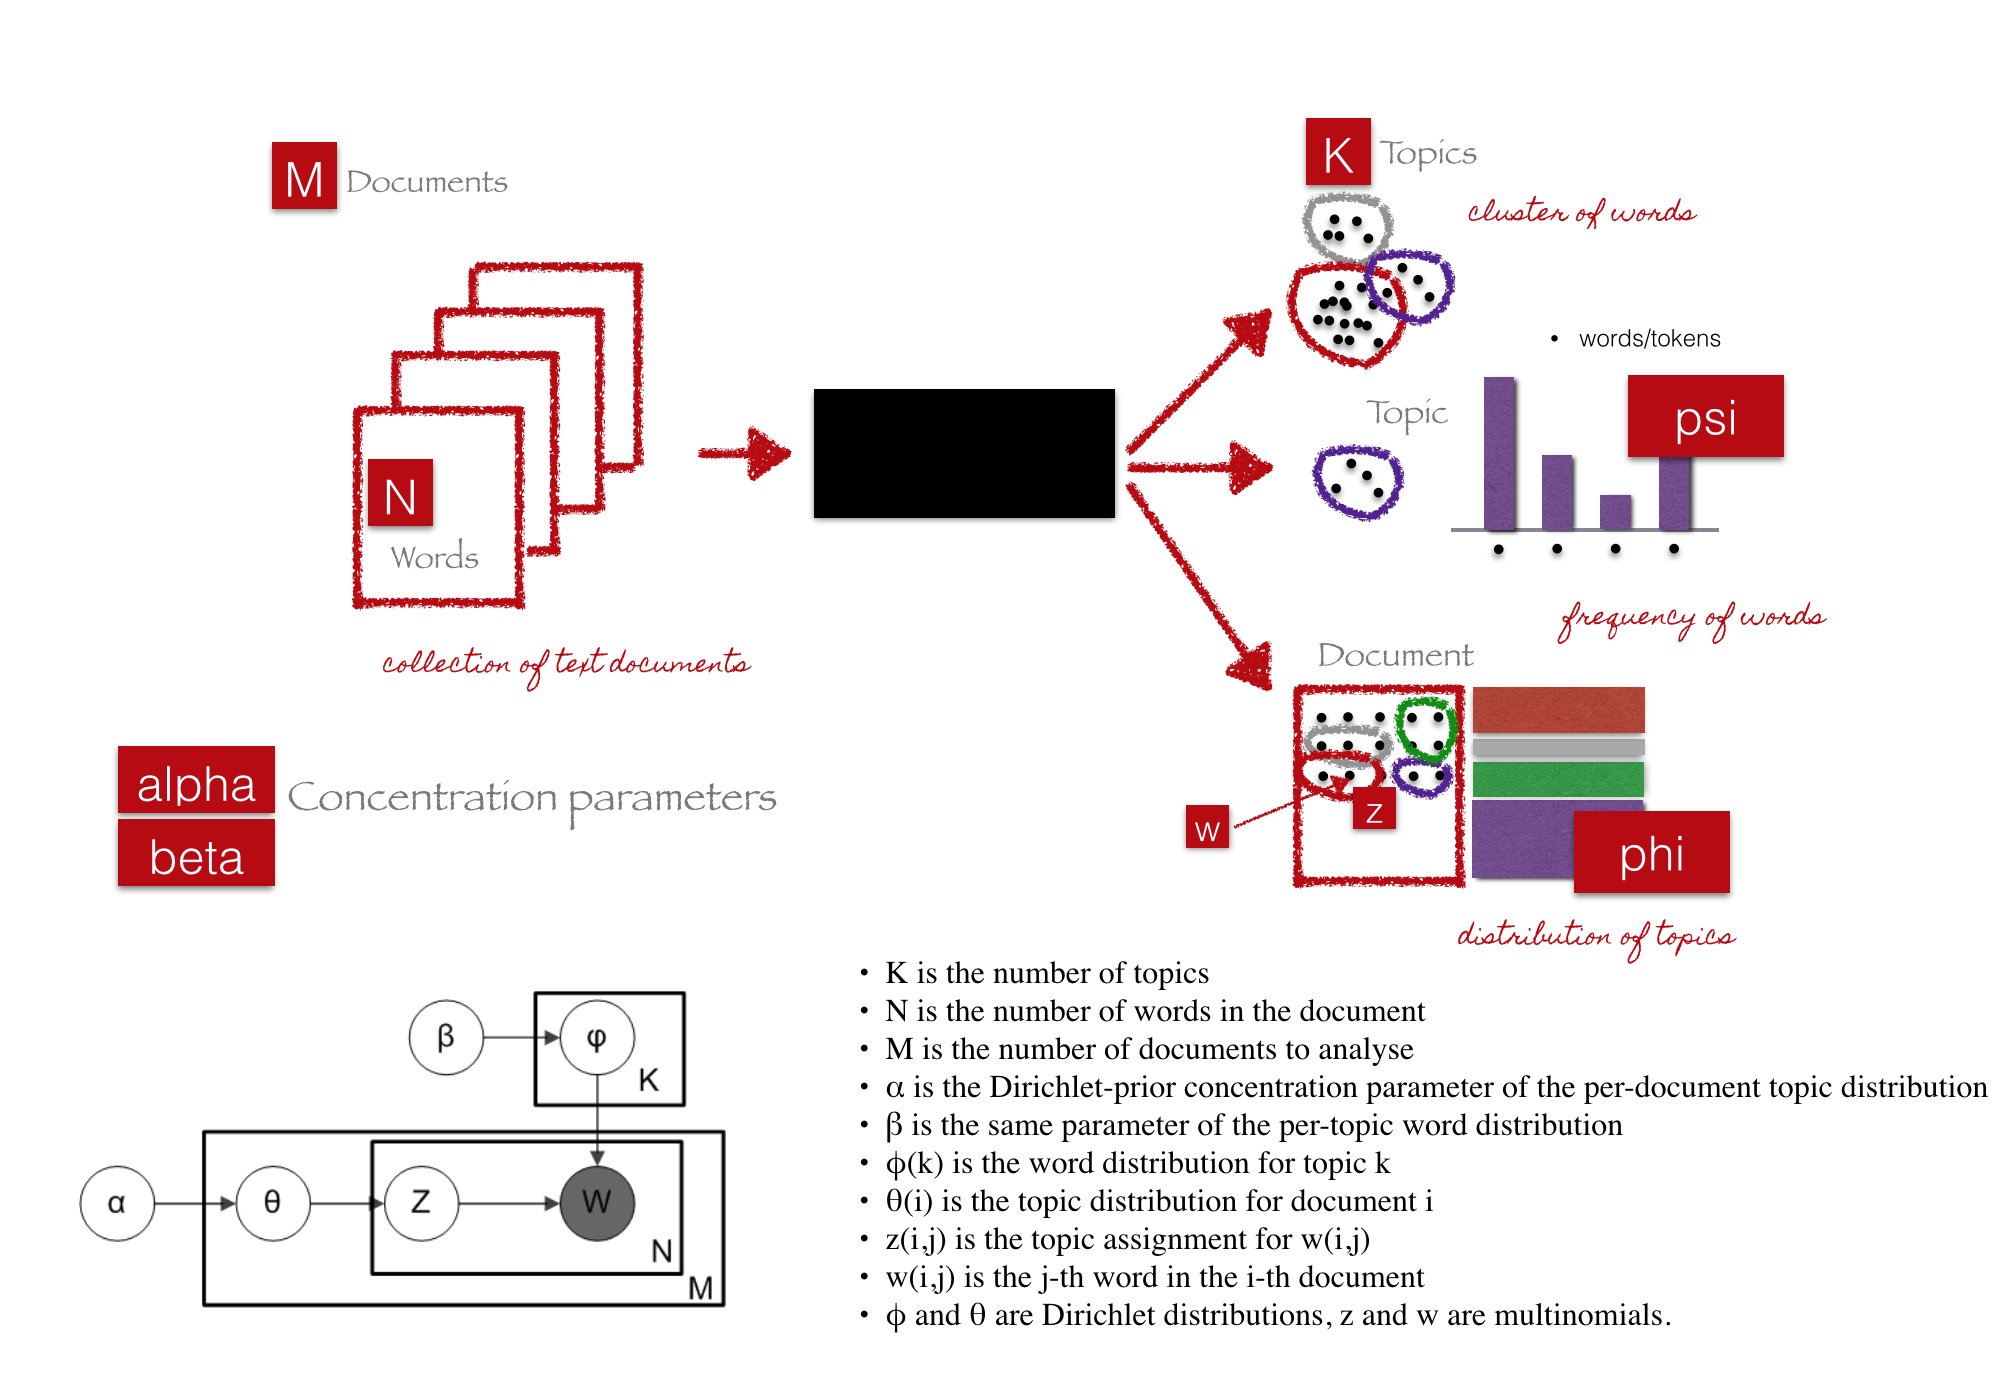

#### Most common topic modeling algorithms :     


1.   Latent Semantic Analysis (LSA/LSI)
2.   Probabilistic Latent Semantic Analysis (pLSA)
3.   Latent Dirichlet Allocation (LDA)

#### In this notebook we are going to implement LDA on PMBOK


## 1. LDA Implementation

#### Create the Document-Word matrix
##### The LDA topic model algorithm requires a document word matrix as the main input.
 To create the doc-word matrix, you need to first initialise the CountVectorizer class with the required configuration and then apply fit_transform to actually create the matrix.


In [ ]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

#### Check the Sparsicity
##### Sparsicity is the percentage of non-zero datapoints in the document-word matrix. In other words it's the proportion of sparse entries in the entire matrix

In [ ]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  11.784839314022195 %


#### Building the model


In [ ]:
lda_model = LatentDirichletAllocation(n_components=9,             # Number of topics
                                      max_iter=100,               # Max learning iterations
                                      learning_decay= 0.5,
                                      #learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print("Model attributes \t",lda_model) 

Model attributes 	 LatentDirichletAllocation(learning_decay=0.5, max_iter=100, n_components=9,
                          n_jobs=-1, random_state=100)


#### Diagnose model performance with perplexity and log-likelihood

In [ ]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -67871.14778182782
Perplexity:  106.26823708827695
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.5,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 100,
 'mean_change_tol': 0.001,
 'n_components': 9,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


#### GridSearch to choose the best LDA parapeters
##### The most important tuning parameters for LDA models is n_components (number of topics) and learning_decay (which controls the learning rate) as well.
GridSearch constructs multiple LDA models for all possible combinations of param values in the param_grid dict.

In [ ]:
# Define Search Param
search_params = {'n_components': [12,9,10, 15, 20, 25, 30], 'learning_decay': [.4,.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.4, 0.5, 0.7, 0.9],
                         'n_components': [12, 9, 10, 15, 20, 25, 30]})

In [ ]:
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 9}
Best Log Likelihood Score:  -16590.98956954624
Model Perplexity:  112.43283407438217


#### The dominant topic in each Corpus
##### To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.

In [ ]:
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Titles" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,dominant_topic
Titles0,0.170000,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Titles1,0.000000,0.450000,0.130000,0.000000,0.000000,0.410000,0.000000,0.000000,0.000000,1
Titles2,0.010000,0.010000,0.950000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,2
Titles3,0.000000,0.000000,0.830000,0.000000,0.000000,0.150000,0.000000,0.000000,0.000000,2
Titles4,0.010000,0.930000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,1
Titles5,0.010000,0.010000,0.010000,0.010000,0.010000,0.950000,0.010000,0.010000,0.010000,5
Titles6,0.010000,0.010000,0.290000,0.660000,0.010000,0.010000,0.010000,0.010000,0.010000,3
Titles7,0.000000,0.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Titles8,0.010000,0.270000,0.690000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,2
Titles9,0.080000,0.660000,0.060000,0.000000,0.000000,0.190000,0.000000,0.000000,0.000000,1


#### Check the Topic’s keywords

In [ ]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,requirement,project,register,document,process,scope,documentation,lesson,learn,plan,business,traceability,matrix,management,deliverable
Topic 1,project,process,scope,management,plan,cost,factor,technique,decision,enterprise,work,environmental,document,analysis,wbs
Topic 2,project,describe,section,product,level,include,scope,use,requirement,work,plan,information,component,deliverable,management
Topic 3,estimate,cost,duration,project,use,include,analysis,number,technique,datum,level,work,estimating,alternative,activity
Topic 4,activity,schedule,resource,duration,project,start,relationship,path,date,list,use,milestone,network,sequence,model
Topic 5,project,management,process,plan,schedule,tool,organizational,asset,cost,control,document,activity,figure,information,estimate
Topic 6,cost,performance,work,schedule,plan,project,change,baseline,value,measurement,variance,budget,management,earn,control
Topic 7,project,dependency,work,team,system,activity,use,time,show,base,value,schedule,complete,figure,speci
Topic 8,section,describe,project,management,change,reserve,process,update,include,result,limited,cost,schedule,baseline,plan


In [ ]:
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
df_topic_keywords

,accept,acceptance,accomplish,account,accuracy,action,activity,actual,additional,agile,...,update,use,validate,value,variance,various,way,wbs,well,work
Topic0,5.074018,17.216817,0.111132,0.111111,0.111122,2.924829,0.111153,0.111159,0.908060,0.111131,...,21.850827,1.209530,18.517291,0.464700,0.111140,0.111111,0.111141,0.111125,0.586975,11.193199
Topic1,0.111204,0.133686,3.433268,0.111129,0.111125,2.624009,0.424514,0.111119,0.111136,0.111356,...,9.381086,2.689317,6.704593,0.111117,0.111112,1.303331,3.896206,25.161589,0.111138,30.239141
Topic2,4.395372,0.982778,3.371664,0.111304,2.879316,0.111849,9.817773,0.111128,3.010832,9.055710,...,0.111134,51.143531,0.111176,0.111157,0.111117,6.168332,3.682023,5.759932,4.806471,49.240366
Topic3,0.606036,0.111118,0.111217,0.111201,15.621718,0.111222,18.631942,1.122881,8.103853,0.111148,...,0.111146,48.400287,0.111164,7.724442,0.111112,0.111254,2.289388,0.111155,0.111149,21.888148
Topic4,0.111134,0.111111,0.111166,2.232354,0.111160,0.111125,272.749021,0.111115,4.474295,0.111159,...,10.073253,36.981274,0.111113,0.111126,0.111121,0.111153,5.362285,0.111169,5.401588,9.379178
Topic5,0.111111,0.111121,0.111141,0.111121,0.111136,2.257291,36.668604,0.111126,0.111173,3.166014,...,29.881658,5.546132,0.111144,0.111117,0.111117,1.137403,0.111172,0.111142,0.111141,6.111957
Topic6,1.271111,0.111111,8.528036,13.765231,1.832105,6.298823,2.313781,33.342405,0.111157,0.111137,...,4.123336,21.815619,0.111124,61.710858,52.272784,0.111261,2.379338,3.411508,1.259401,99.977959
Topic7,1.208788,0.111119,0.111163,0.111133,0.111162,1.719496,20.570347,0.111203,0.111177,0.111234,...,0.111144,16.988729,0.111234,12.544307,0.111146,0.111345,4.057270,0.111241,0.111145,29.897863
Topic8,0.111225,0.111139,0.111213,9.335416,0.111157,24.841355,7.712865,8.867864,7.058319,0.111111,...,42.356416,17.225581,0.111161,0.111175,4.949352,2.834810,0.111178,0.111140,6.500991,3.072190


#### Topics distribution

In [ ]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Title")
df_topic_distribution.columns = ['Topic Num', 'Num Title']
df_topic_distribution

,Topic Num,Num Title
0,2,44
1,3,31
2,4,28
3,5,26
4,8,22
5,1,21
6,6,21
7,0,18
8,7,5


#### Visualize the LDA model with pyLDAvis
##### The pyLDAvis offers the best visualization to view the topics-keywords distribution.

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      111.092506 -133.722946       1        1  15.480028
2       34.946613  107.064590       2        1  14.786702
5      -28.088213 -159.949036       3        1  14.367532
6      147.698074   21.369604       4        1  14.241698
1      -97.501183  126.981384       5        1  10.272422
0       30.312096  -32.794945       6        1   9.886516
8     -155.443665 -118.494690       7        1   8.855287
3     -204.248108   22.596130       8        1   8.451469
7      -79.404678   -6.864717       9        1   3.658347, topic_info=             Term        Freq       Total Category  logprob  loglift
206   requirement  245.000000  245.000000  Default  30.0000  30.0000
216       section  275.000000  275.000000  Default  29.0000  29.0000
6        activity  364.000000  364.000000  Default  28.0000  28.0000
87       estimate  267.000000  267.000000  Default  27.0000  27.0000
67       describe  278.000000  278.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
14       analysis    7.786571  150.370688   Topic9  -4.2245   0.3475
185       process    6.649949  346.200024   Topic9  -4.3823  -0.6442
200  relationship    5.450342   56.338469   Topic9  -4.5812   0.9725
141    management    5.752949  406.927857   Topic9  -4.5272  -0.9508
175          plan    5.643894  383.897908   Topic9  -4.5463  -0.9116

[438 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         2  0.314428  accept
0         4  0.078607  accept
0         6  0.393034  accept
0         8  0.078607  accept
0         9  0.078607  accept
...     ...       ...     ...
256       5  0.113365    work
256       6  0.043000    work
256       7  0.011727    work
256       8  0.086001    work
256       9  0.117274    work

[943 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 6, 7, 2, 1, 9, 4, 8])

#### Predict the topics for a new piece of text

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["The scope management process"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['project', 'management', 'plan', 'process', 'document', 'scope', 'tool', 'cost', 'datum', 'figure', 'technique', 'control', 'enterprise', 'factor', 'organizational']


#### Clustering Corpus that share similar topics and plot
We use k-means clustering on the document-topic probabilioty matrix, which is nothing but lda_output object.

For the X and Y, you can use SVD on the lda_output object with n_components as 2. SVD ensures that these two columns captures the maximum possible amount of information from lda_output in the first 2 components

In [ ]:
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=9, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 9 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.18  0.18  0.79  0.32  0.25  0.23  0.2   0.07  0.22]
 [ 0.03  0.18 -0.43  0.1   0.11  0.86  0.07  0.02  0.14]]
Perc of Variance Explained: 
 [0.06 0.17]


Let’s plot the document along the two SVD decomposed components. The color of points represents the cluster number.

Text(0.5, 1.0, 'Segregation of Topic Clusters')

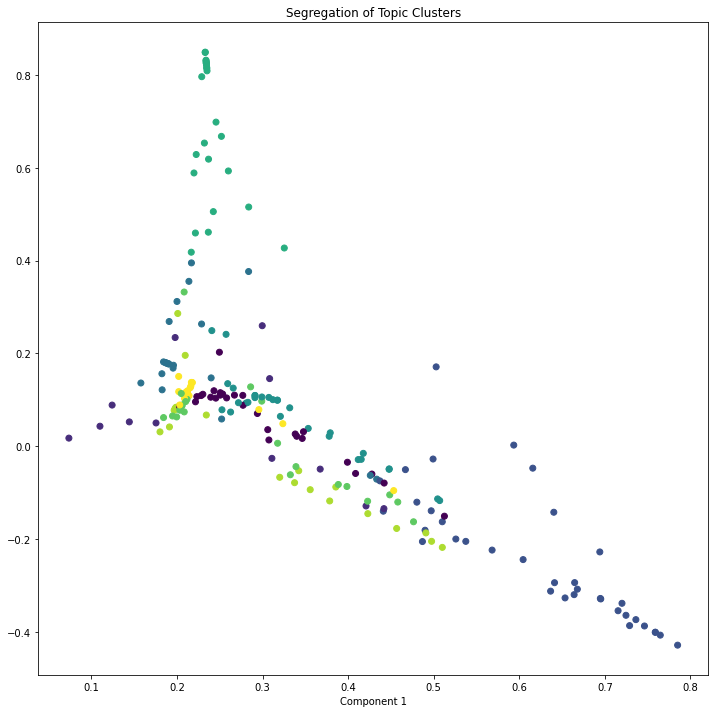

In [ ]:
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

#### Get similar corpus for any given piece of text

Since we can get the probaility of topics for a given document (using predict_topic()), we can compute the euclidean distance with the probability scores of all other documents.

The most similar documents are the ones with the smallest distance.

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def similar_corpus(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [ ]:
mytext = ["Scope management is a process"]
doc_ids, docs = similar_corpus(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:500])

Topic KeyWords:  ['project', 'management', 'plan', 'process', 'scope', 'document', 'tool', 'figure', 'datum', 'technique', 'work', 'schedule', 'control', 'enterprise', 'input']
Topic Prob Scores of text:  [[0.  0.  0.  0.  0.  0.  0.  0.8 0. ]]
Most Similar Doc's Probs:   [[0.  0.  0.  0.  0.  0.  0.  0.9 0. ]]

  Veriﬁed deliverables are project deliverables that are completed and checked for correctness through the Control  Quality process. 
